In [1]:
# coding: utf-8

#!/usr/bin/env python3
"""
Created September 2019
@author: masonf3 (Mason Friedman)
"""
'''
NYS_profiler_save_and_plot.py
Make 1-day plots and saves daily .csv files of key weather variables for NYS Profiler stations.
Some code modified from Joe Zagrodnik's 'plot_mesowest_3day.py', used for similar task in the OLYMPEX field campaign.
Code to read in data developed by Nathan Bain's 'read_profiler_data.py', used at NYS Mesonet.

**File Saving Information**
CSV files, one per day, save to: *insert Stacy's directory*
1-day plots, one per hour, save to: *insert Stacy's directory*
'''
import os 
import json            #javascript object notation encoder and decoder
import pandas as pd
import time, datetime, glob
from time import strftime 
from datetime import datetime, timedelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
# matplotlib.use('Agg') 
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
import matplotlib.transforms as transforms
from matplotlib.cbook import get_sample_data
import xarray as xr
from PIL import Image
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Number of contours for the LIDAR plots (must be a float)
bin_number = 20.

/home/disk/meso-home/jfinlon/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [13]:
import pandas as pd
import json
import numpy as np
test_file = '/home/disk/data/albany/profiler/20200112/2011-resampled.PROF_ALBA.json'
data = json.load(open(test_file, "r"))

In [14]:
import xarray as xr
mwr = data['mwr']
mwr = xr.Dataset.from_dict(mwr)
mwr = xr.decode_cf(mwr)
t = mwr['temperature'].to_dataframe()
p = mwr['pressure_level'].to_dataframe()

In [15]:
p

lv2_processor  pressure_level
time                range                              
2020-01-11T20:10:00 0        Angle20(A)          1002.3
                    50       Angle20(A)           996.5
                    100      Angle20(A)           990.7
                    150      Angle20(A)           984.9
                    200      Angle20(A)           979.1
...                                 ...             ...
2020-01-12T19:50:00 9000     Angle20(A)           298.6
                    9250     Angle20(A)           287.6
                    9500     Angle20(A)           277.0
                    9750     Angle20(A)           266.7
                    10000    Angle20(A)           256.8

[8294 rows x 2 columns]

In [65]:
theta = (t['temperature']+273.15) * (1000. / p['pressure_level']) ** (2./7.)

In [86]:
mwr_4panel_df = pd.concat([t.iloc[:,1], p.iloc[:,1], (temp_var.to_dataframe()).iloc[:,1]], axis=1)
mwr_4panel_df

temperature  pressure_level  temperature
time                range                                          
2020-01-09T23:50:00 0             -4.6          1029.6   266.321100
                    50            -4.8          1023.1   266.604737
                    100           -5.0          1016.6   266.891605
                    150           -5.1          1010.1   267.281468
                    200           -5.2          1003.7   267.667410
...                                ...             ...          ...
2020-01-10T23:30:00 9000         -42.5           311.7   321.810409
                    9250         -44.4           300.5   322.513869
                    9500         -46.1           289.6   323.514199
                    9750         -47.8           279.0   324.531130
                    10000        -49.5           268.7   325.563181

[8294 rows x 3 columns]

In [50]:
# print(type(theta), type(t['temperature']))
mwr['temperature']['range']

<xarray.DataArray 'range' (range: 58)>
array([    0,    50,   100,   150,   200,   250,   300,   350,   400,   450,
         500,   600,   700,   800,   900,  1000,  1100,  1200,  1300,  1400,
        1500,  1600,  1700,  1800,  1900,  2000,  2250,  2500,  2750,  3000,
        3250,  3500,  3750,  4000,  4250,  4500,  4750,  5000,  5250,  5500,
        5750,  6000,  6250,  6500,  6750,  7000,  7250,  7500,  7750,  8000,
        8250,  8500,  8750,  9000,  9250,  9500,  9750, 10000])
Coordinates:
    lv2_processor  <U10 ...
  * range          (range) int64 0 50 100 150 200 ... 9000 9250 9500 9750 10000
Attributes:
    standard_name:  height
    units:          m
    long_name:      height above the surface

In [88]:
temp_var = mwr['temperature'].copy()
temp_var.values = theta.values.reshape(mwr['temperature'].shape)
temp_var.attrs['units'] = 'K'
temp_var = temp_var.rename('theta')

In [89]:
temp_var = temp_var.to_dataframe()
temp_var

lv2_processor       theta
time                range                          
2020-01-09T23:50:00 0        Angle20(A)  266.321100
                    50       Angle20(A)  266.604737
                    100      Angle20(A)  266.891605
                    150      Angle20(A)  267.281468
                    200      Angle20(A)  267.667410
...                                 ...         ...
2020-01-10T23:30:00 9000     Angle20(A)  321.810409
                    9250     Angle20(A)  322.513869
                    9500     Angle20(A)  323.514199
                    9750     Angle20(A)  324.531130
                    10000    Angle20(A)  325.563181

[8294 rows x 2 columns]

In [32]:
#calculations
def e_calc(Td):
    '''Given dew point, returns vapor pressure.
    
    Parameters:
    Td (float): Dew point temperature, in degrees C
    
    Returns:
    e (float): vapor pressure, in hPa
    '''
    e = 6.11*10**((7.5*Td)/(237.3+Td))
    return e
    
def vapor_density_calc(e,T):
    '''Given vapor pressure and temperature, returns vapor density (a.k.a. absolute humidity)
    
    Parameters:
    e (float): vapor pressure, in hPa
    T (float): temperature, in degrees Celsius
    
    Returns:
    Vd (float): vapor density, in kg/m^3
    '''
    e_Pa = e*100            #Pa (kg*m^-1*s^-2)
    T_kelvin = T+273.15     #K
    Rw = 461                #J*K^-1*kg^-1 (m^2*s^-2*K^-1)
    Vd = e_Pa/(Rw*T_kelvin) #kg/m^-3
    return Vd

def rel_humidity_calc(Td,T):
    '''Given dew point temperature and actual temperature, returns a relative humidity value.
    
    Parameters: 
    Td (float): Dew point temperature, in degrees C
    T (float): Actual temperature, in degrees C
    
    Returns:
    RH (float): Relative humidity, in %
    '''
    e = 6.11*10**((7.5*Td)/(237.3+Td))
    es = 6.11*10**((7.5*T)/(237.3+T))
    RH = (e/es)*100
    return RH

def load_data(path,station, curr_dt_string):
    '''Given filepath to data stream with .json files and a profiler station, returns two dataframes with
    microwave radiometer data and a dataframe of lidar data.
    
    Parameters:
    path (filepath): path to directory where data, in .json files, comes in
    station (str): string of station ID
    
    Returns:
    mwr_4panel_df (dataframe): pandas dataframe of microwave radiometer data for the 3panel plot
    mwr_precip_df (dataframe): pandas dataframe of microwave radiometer data for the precip/cloud height plot
    lidar_df (dataframe): pandas dataframe of lidar data for that station
    '''
    mwr = None
    lidar = None
    file_list = glob.glob(path + '/*'  + station + '.json')     #all json files in path directory    
    file_list.sort()
    file_list_trimmed = [] # remove possible files AFTER current/user-specified date
    for file in file_list:
        timestamp = int(file.split('/')[-1][:4])
        if timestamp<=int(curr_dt_string[-4:])+3: # +3 to allow for 3-minute buffer in case files still being saved
            file_list_trimmed.append(file)
    latest_file = file_list_trimmed[-1]
    with open(latest_file, "r") as f:
        data = json.load(f)

        try:    
            mwr = data['mwr']
            mwr = xr.Dataset.from_dict(mwr)
            mwr = xr.decode_cf(mwr)
            # Each field had to broken up to avoid a memory error
            mwr_p = mwr['pressure_level'].to_dataframe()
            mwr_t = mwr['temperature'].to_dataframe()
            mwr_td = mwr['dew_point'].to_dataframe()
            mwr_rh = mwr['relative_humidity'].to_dataframe()
            mwr_lq = mwr['liquid'].to_dataframe()
            mwr_iv = mwr['integrated_vapor'].to_dataframe()
            mwr_il = mwr['integrated_liquid'].to_dataframe()
            mwr_cb = mwr['cloud_base'].to_dataframe()
            mwr_rf = mwr['rain_flag'].to_dataframe()

            # Compute potential temperature
            theta_vals = (mwr['temperature']+273.15) * (1000. / mwr['pressure_level']) ** (2./7.)
            theta = mwr['temperature'].copy()
            theta.values = theta_vals.values.reshape(mwr['temperature'].shape)
            theta.attrs['units'] = 'K'
            theta = theta.rename('theta')
            mwr_th = theta.to_dataframe()

            #Two different dataframes are created- 
            #DF#1 multi index of times->heights->t,td,rh,lq
            #DF#2 single index of times->iv,il,cb,rf
            
            #Second element is concatenated together to drop repetative "angle" columns
            mwr_4panel_df = pd.concat([mwr_t.iloc[:,1], mwr_td.iloc[:,1], mwr_th.iloc[:,1],
                                       mwr_rh.iloc[:,1], mwr_lq.iloc[:,1]], axis=1)
            print('good_here')
            #Rain flags are 30 seconds offset from the other variables 
            #Depending on where the data starts, sometimes the rain flag series will have a different length than the rest of the data by one value
            #The rain index is dropped and replaced with the index of the other data (cb,il,iv)
            data_indeces = mwr_cb.index
            if (len(mwr_rf.index) < len(mwr_cb.index)):
                data_indeces = mwr_cb[:-1].index
            elif (len(mwr_rf.index) > len(mwr_cb.index)):
                mwr_rf = mwr_rf[:-1]

            #Sets the index values to match the other parameters
            mwr_rf = mwr_rf.reset_index(drop=True)
            mwr_rf = mwr_rf.set_index(data_indeces)
            mwr_precip_df = pd.concat([mwr_iv.iloc[:,1],mwr_il.iloc[:,1],mwr_cb.iloc[:,1],mwr_rf.iloc[:,1]],axis=1)
        except:
            print("Problem reading microwave radiometer data for "+station)
            mwr_df = []
            mwr_4panel_df = pd.DataFrame(mwr_df)  
            mwr_precip_df = pd.DataFrame(mwr_df)

        try:
            lidar = data['lidar']
            lidar = xr.Dataset.from_dict(lidar)
            lidar = xr.decode_cf(lidar)
            lidar_df = lidar.to_dataframe()
            lidar_df = pd.DataFrame(lidar_df)
        except:
            print("Problem reading lidar data for "+station)
            lidar_df = []
            lidar_df = pd.DataFrame(lidar_df)
        print()

    return mwr_4panel_df, mwr_precip_df, lidar_df

def plot_mwr(mwr_df, station, station_name, logo_path, curr_dt):
    '''Given microwave radiometer dataframe and a station ID, saves plot of mwr profiler data for the last day at
    that station
    
    Parameters: 
    station (str): string of station ID
    
    Returns:
    None
    '''
    
    #Gets Multi level indeces of time and heights
    times_df = pd.DataFrame(mwr_df.index.get_level_values(0).values)
    times_array = np.array(times_df.drop_duplicates()[0].values)
    heights_df = pd.DataFrame(mwr_df.index.get_level_values(1).values)
    
    #Flips the height vector since rows run from top to bottom
    heights_array = np.flip(np.array(heights_df.drop_duplicates()[0].values))
    datetimes_array = pd.to_datetime(times_array)
    
    graphtimestamp_start=datetimes_array[0].strftime("%H UTC %m/%d/%y")        #start date, for fig title
    graphtimestamp_end=datetimes_array[-1].strftime("%H UTC %m/%d/%y")         #end date, for fig title
    timestamp_end = datetimes_array[-1].strftime('%Y%m%d%H%M')          #timestamp end for saving plots
    today_date = datetimes_array[-1].strftime('%Y%m%d')

    #Fills arrays for contour plotting
    temps_array = np.zeros([len(heights_array),len(times_array)])
    th_array = np.zeros([len(heights_array),len(times_array)])
    lq_array = np.zeros([len(heights_array),len(times_array)])
    rh_array = np.zeros([len(heights_array),len(times_array)])
    for i in range(0,len(times_array)):
        for j in range(0,len(heights_array)):
            temps_array[j,i] = mwr_df.loc[(times_array[i],heights_array[j]),'temperature']
            th_array[j,i] = mwr_df.loc[(times_array[i],heights_array[j]),'theta']
            lq_array[j,i] = mwr_df.loc[(times_array[i],heights_array[j]),'liquid']
            rh_array[j,i] = mwr_df.loc[(times_array[i],heights_array[j]),'relative_humidity']

    fig = plt.figure(figsize = (16, 14))
#     fig.suptitle('{} ({}) Microwave Radiometer\n{} - {}'.format(station_name, station, graphtimestamp_start,
#                                                                 graphtimestamp_end),x=0.44, y = 0.92,fontsize = 24)
    axes = []
    ax1 = fig.add_subplot(4,1,1)
    
    #TEMPERATURE PLOT
    #ax1.set_title('Temperature',fontsize = 20,fontweight="bold")
    temp = ax1.contourf(datetimes_array,heights_array/1000.,temps_array,levels=np.arange(-50,51,2),cmap='seismic')
    contour = ax1.contour(datetimes_array,heights_array/1000.,temps_array,levels=np.arange(-50,51,10),colors='grey')
    plt.clabel(contour,fmt='%1.f',colors = 'green')
    cb = plt.colorbar(temp)
    cb.set_ticks(np.arange(-50,51,10))
    cb.set_ticklabels(np.arange(-50,51,10))
    cb.ax.tick_params(labelsize=16)
    cb.set_label('Temperature ($^\circ$C)', fontsize = 20)
    ax1.set_title('{} ({}) MWR Products\n{} - {}'.format(station_name, station, graphtimestamp_start,
                                                                 graphtimestamp_end), fontsize = 24)
    axes.append(ax1)
    
    #POTENTIAL TEMPERATURE PLOT
    ax1b = fig.add_subplot(4,1,2)
    theta = ax1b.contourf(datetimes_array,heights_array/1000.,th_array,levels=np.arange(250,361,2),cmap='gist_ncar')
    contour = ax1b.contour(datetimes_array,heights_array/1000.,th_array,levels=np.arange(250,361,10),colors='grey')
    plt.clabel(contour,fmt='%1.f',colors = 'green')
    cb = plt.colorbar(theta)
    cb.set_ticks(np.arange(250,361,20))
    cb.set_ticklabels(np.arange(250,361,20))
    cb.ax.tick_params(labelsize=16)
    cb.set_label('$\Theta$ (K)', fontsize = 20)
    axes.append(ax1b)

    #LIQUID PLOT
    ax2 = fig.add_subplot(4,1,3)
    #ax2.set_title('Liquid',fontsize = 20,fontweight="bold")

    #Gets the lower and upper ends of the log of the data
    lev_exp = np.arange(np.floor(np.log10(lq_array.min())), np.ceil(np.log10(lq_array.max()))+.125,.125)
    levs = np.power(10, lev_exp) #Creates logarithmic levels for contours
    lq = ax2.contourf(datetimes_array,heights_array/1000.,lq_array,levels=levs,cmap='rainbow')

    #Contours only every 8th level (10^-2,10^-1,10^0)
    contour = ax2.contour(datetimes_array,heights_array/1000.,lq_array,levels=levs[8::8],colors='black')
    fmt = matplotlib.ticker.LogFormatterMathtext() #Makes the labels in log format 
    plt.clabel(contour,contour.levels,fmt=fmt,colors = 'white')
    norm = matplotlib.colors.LogNorm(vmin = .001, vmax = 1) 
    sm = plt.cm.ScalarMappable(norm=norm, cmap = lq.cmap)
    sm.set_array([])
    cb = plt.colorbar(sm)
    cb.set_ticks(levs[::8])
    cb.set_ticklabels(['$10^-3$','$10^-2$','$10^-1$','$10^0$'])
    cb.ax.tick_params(labelsize=16)
    cb.set_label('Liquid (g m$^{-3}$)', fontsize = 20)
    axes.append(ax2)
    
    #RH PLOT
    ax3 = fig.add_subplot(4,1,4)
    #ax3.set_title('Relative Humidity',fontsize = 20,fontweight="bold")
    rh = ax3.contourf(datetimes_array,heights_array/1000.,rh_array,levels=np.arange(0,110,5),cmap='BrBG')
    contour = ax3.contour(datetimes_array,heights_array/1000.,rh_array,levels=np.array([40,60,80,90,99]))
    plt.clabel(contour,contour.levels,fmt='%1.f')
    cb = plt.colorbar(rh)
    cb.set_ticks(np.arange(0,110,20))
    cb.set_ticklabels(np.arange(0,110,20))
    cb.ax.tick_params(labelsize=16)
    cb.set_label('RH (%)',fontsize=20)
    
    ax3.set_xlabel('Time (UTC)', fontsize=20)
    ax3.get_xaxis().set_label_coords(0.5,-0.15)                         #properly places x-label away from figure
    axes.append(ax3)

    #Plots the times from x-axis of each plot
    for ax in axes:
        ax.set_ylabel('Height (km)',fontsize = 20)
        ax.tick_params(axis='x',which='both',bottom='on',top='off')     #add ticks at labeled times
        ax.tick_params(axis='y',which='both',left='on',right='off', labelsize=20)
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)
        ax.set_xlim(curr_dt-timedelta(hours=24), curr_dt)
        ax.yaxis.grid(linestyle = '--')   
        ax.xaxis.set_major_locator( DayLocator(interval = 1) )          #one date written per day
        ax.xaxis.set_major_formatter( DateFormatter('%b-%d') )          #show date, written as 'Jul-12'
        ax.xaxis.set_minor_locator( HourLocator(byhour=range(2,24,2),interval = 1) ) #hour labels every 6 hours
        ax.xaxis.set_minor_formatter( DateFormatter('%H UTC') )            #show hour labels
        ax.get_yaxis().set_label_coords(-0.04,0.5)                      #properly places y-labels away from figure
        ax.xaxis.get_major_ticks()[0].label.set_fontsize(20)
        for tick in ax.xaxis.get_minor_ticks():
            tick.label.set_fontsize(16)
            
    # Add mesonet logo
    fig.subplots_adjust(bottom=0.1,left=.05,right=1.1)
    im = plt.imread(get_sample_data(logo_path))
    new_ax = fig.add_axes([1, 0, 0.1, 0.1])
    new_ax.imshow(im)
    new_ax.axis('off')

    #Saves the plots
#     plot_path = plot_mwr_dir+'/'+today_date
#     if not os.path.exists(plot_path):
#             os.mkdir(plot_path)
#     plt.savefig(plot_path+'/ops.nys_mwr_ts.'+timestamp_end+'.'+station.lower()+'.png',bbox_inches='tight')
#     plt.savefig('sample_mwr.png', bbox_inches='tight')
    plt.show()
    plt.clf, plt.cla(), plt.close()
    print('plotted MWR for ' + station)

def lidar_field_plotting(station, station_name, lidar_df, field, logo_path, curr_dt):
    '''Takes in the lidar data and will produce a plot of either CNR, Horizonal Speed or Vertical Speed
       for a specific station.  Each plot will range from 100m to 3000m and will have wind barbs with the direction of wind.
    
        Parameters:
        station (str): string of the 4 character station name.
        lidar_df (dataframe): pandas dataframe of lidar data for that station.
        field (string): must be one of ['cnr', 'w', 'velocity']
    '''
    #Gets the heights which are the first level index between 100-3000m
    heights_df = pd.DataFrame(lidar_df.index.get_level_values(0).values)
    heights_df = heights_df.loc[(heights_df[0] >= 100) & (heights_df[0] <= 3000)]
    
    #Flips array for plottign
    heights_array = np.flip(np.array(heights_df.drop_duplicates()[0].values))
    times_df = pd.DataFrame(lidar_df.index.get_level_values(1).values)
    times_array = np.array(times_df.drop_duplicates()[0].values)
    datetimes_array = pd.to_datetime(times_array)
    
    graphtimestamp_start=datetimes_array[0].strftime("%H UTC %m/%d/%y")        #start date, for fig title
    graphtimestamp_end=datetimes_array[-1].strftime("%H UTC %m/%d/%y")         #end date, for fig title
    timestamp_end = datetimes_array[-1].strftime('%Y%m%d%H%M')          #timestamp end for saving plots
    today_date = datetimes_array[-1].strftime('%Y%m%d')

    #Field array is array to be plotted
    field_array = np.zeros([len(heights_array),len(times_array)])
    
    #Background array allows for the figure background color to be customized
    background = np.zeros([len(heights_array),len(times_array)])
    Uwind = np.zeros([len(heights_array),len(times_array)], dtype= np.float)
    Vwind = np.zeros([len(heights_array),len(times_array)], dtype= np.float)
    
    #Fills withs nans, so absent data does not show up on the plot
    Uwind.fill(np.nan)
    Vwind.fill(np.nan)
    
    for i in range(0,len(times_array)):
        for j in range(0,len(heights_array)):
            field_array[j,i] = lidar_df.loc[(heights_array[j],times_array[i]),field]
            direction = lidar_df.loc[(heights_array[j],times_array[i]),'direction']
            velocity = lidar_df.loc[(heights_array[j],times_array[i]),'velocity']
            if (j % 2 == 0) and (i % 2 == 0): #Takes every other row and column of data
                #direction is 450 degrees offset from plotting orientation
                Uwind[j,i] = np.cos((450. - direction)/180.*np.pi)*velocity 
                Vwind[j,i] = np.sin((450. - direction)/180.*np.pi)*velocity 
            
    #Gets the smallest and largest non-nan of the data
    field_max = np.nanmax(field_array)
    field_min = np.nanmin(field_array)
    
    #Gets the binsize based off the amount of bins defined globally
    binsize = (field_max - field_min)/bin_number
    levs = np.arange(np.floor(field_min), np.ceil(field_max), binsize)

    if field == 'w': #Rounds the levels more precisely and chooses another cmap
        levs = np.round(levs,2)
        colormap = 'seismic'
    else:
        levs = np.round(levs)
        colormap = 'cool'
        if field == 'cnr':
            field_array[np.where(field_array<levs[2])] = np.nan
    
    fig, ax = plt.subplots(figsize = (16, 10))
    
    ### CONTOURING
    ax.contourf(datetimes_array,heights_array/1000.,background, colors = 'aliceblue') #Background color
    color_plot = ax.contourf(datetimes_array,heights_array/1000.,field_array,levels = levs, cmap=colormap)
    ax.barbs(datetimes_array,heights_array/1000.,Uwind,Vwind,length = 7)
    #Only plots contours for vertical velocity or CNR data
    if field == 'w' or field == 'cnr':
        contour = ax.contour(datetimes_array,heights_array/1000.,field_array,levels=levs[::4],colors='black')
        plt.clabel(contour,fmt='%1.1f',colors='white')

    cb = plt.colorbar(color_plot)
    cb.set_ticks(levs)
    cb.set_ticklabels(levs)
    cb.ax.tick_params(labelsize=14)
    
    #W and velocity have the same units
    if field == 'cnr':
        cb.set_label('dB',fontsize = 20)
        field_title = 'Carrier-to-Noise Ratio (CNR)'
        save_name = field
    elif field == 'w': 
        cb.set_label('m s$^{-1}$',fontsize=20)
        field_title = 'Vertical Velocity'
        save_name = 'vert_wspd'
    elif field == 'velocity':
        cb.set_label('kt',fontsize=20)
        field_title = 'Horizontal Velocity'
        save_name = 'horz_wspd'
    else:
        cb.set_label('dB',fontsize = 20)
        field_title = field.upper()
        save_name = field
        
#     fig.suptitle(station.upper()+ ' ' + field_title + ' ' + graphtimestamp_start+' - '+graphtimestamp_end, fontsize = 24, x=0.44, y = 0.92)
    ax.set_title('{} ({}) Lidar {}\n{} - {}'.format(station_name, station, field_title, graphtimestamp_start,
                                                                graphtimestamp_end), fontsize = 24)
    #ax.set_title(''.format())
    #Axis Ticks   
    height_ticks = np.array([0.1,0.5,1,1.5,2,2.5,3])
    ax.set_yticks(height_ticks)
    ax.set_yticklabels(height_ticks, fontsize = 16)
    ax.set_ylim(0.1,3)
    ax.set_ylabel('Height (km)', fontsize = 20)
    
    #X axis time ticks
    ax.set_xlabel('Time (UTC)', fontsize=20)
#     ax.get_xaxis().set_label_coords(0.5,-0.15)
    ax.tick_params(axis='x',which='both',bottom='on',top='off')                  #add ticks at labeled times
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)
    ax.yaxis.grid(linestyle = '--')
    ax.set_xlim(curr_dt-timedelta(hours=24), curr_dt)
    ax.xaxis.set_major_locator( DayLocator(interval = 1), )                      #one date written per day
    ax.xaxis.set_major_formatter( DateFormatter('%b-%d'))                        #show date, written as 'Jul-12'
    ax.xaxis.set_minor_locator( HourLocator(byhour=range(2,24,2),interval = 1) ) #hour labels every 6 hours
    ax.xaxis.set_minor_formatter( DateFormatter('%HZ'))                          #show hour labels
    ax.get_yaxis().set_label_coords(-0.04,0.5)
    ax.xaxis.get_major_ticks()[0].label.set_fontsize(20)
    for tick in ax.xaxis.get_minor_ticks():
        tick.label.set_fontsize(16)
    
    # Add mesonet logo
    fig.subplots_adjust(bottom=0.1,left=.05,right=1.1)
    im = plt.imread(get_sample_data(logo_path))
    new_ax = fig.add_axes([1, 0, 0.1, 0.1])
    new_ax.imshow(im)
    new_ax.axis('off')
    
    #saves plots
#     plot_path = plot_lidar_dir+'/'+today_date
#     if not os.path.exists(plot_path):
#             os.mkdir(plot_path)
#     plt.savefig(plot_path+'/ops.nys_lidar_' + save_name + '.' + timestamp_end+'.'+station.lower()+'.png',bbox_inches='tight')
    plt.show()
    plt.clf, plt.cla(), plt.close()
    print('plotted ' + field + ' Lidar' + ' for ' + station)

def  plot_cloud_liquid(mwr_df, station, station_name, logo_path, curr_dt):
    '''Takes in a df with field variables integrated vapor, integrated liquid, cloud base (km), and a rain flag of either 0.0 or 1.0.
       Outputs a scatter plot of the df variable with the left axis in meters and the right axis in mm liquid/ cm vapor.
    '''
    times_df = pd.DataFrame(mwr_df.index.get_level_values(0).values)
    times_array = np.array(times_df.drop_duplicates()[0].values)
    datetimes_array = pd.to_datetime(times_array)
    
    graphtimestamp_start=datetimes_array[0].strftime("%H UTC %m/%d/%y")        #start date, for fig title
    graphtimestamp_end=datetimes_array[-1].strftime("%H UTC %m/%d/%y")         #end date, for fig title
    timestamp_end = datetimes_array[-1].strftime('%Y%m%d%H%M')          #timestamp end for saving plots
    today_date = datetimes_array[-1].strftime('%Y%m%d')
    
    fig, axL = plt.subplots(figsize = (16,10))

#     fig.suptitle(station.upper()+ ' Cloud & Liquid Parameters ' + graphtimestamp_start + 
#                  ' - '+ graphtimestamp_end, fontsize = 24, x = .5, y = 0.92)
    axL.set_title('{} ({}) Derived MWR Products\n{} - {}'.format(
        station_name, station, graphtimestamp_start, graphtimestamp_end), fontsize = 24)
    
    #Height axis for cloud base height 
    height_ticks = np.arange(0,11,1)
    axL.set_ylim(0,10)
    axL.set_yticks(height_ticks)
    axL.set_yticklabels(height_ticks, fontsize = 16)
    axL.set_ylabel('Height (km)', fontsize = 20)
    
    #Right axis for integrated liquid/vapor
    axR = axL.twinx()
    axR.set_ylim(0,10)
    axR.set_yticks(height_ticks)
    axR.set_yticklabels(height_ticks, fontsize = 16)
    axR.set_ylabel('Integrated Moisture (mm liquid | cm vapor)', fontsize = 20)
    
    #Gets the values of the rain flag which are non-zero and thus represent rain
    rain = mwr_df['rain_flag'].values
    rain_indices = np.where( rain != 0.0 )[0]
    
    #Plots a vertical line for rainfall, and saves the last line as an object for the legend
    try:
        for rainy_time in datetimes_array[rain_indices][:-1]:
            axL.axvline(rainy_time,color = 'g',alpha=.5)
        rf = axL.axvline(datetimes_array[rain_indices][-1],color = 'g',alpha=.5)
    except:
        rf = axL.axvline(0,color = 'g',alpha=0)
    
    # SCATTER PLOTS
    cb = axL.scatter(datetimes_array.values, mwr_df['cloud_base'].values,c='black') #in kms
    iv =  axR.scatter(datetimes_array.values,mwr_df['integrated_vapor'].values,c='red')
    il = axR.scatter(datetimes_array.values,mwr_df['integrated_liquid'].values,c='blue')
    
    axR.legend((cb,iv,il,rf) , ("Cloud Base","Integrated Vapor", "Integrated Liquid", "Rain Flag"), fontsize = 16)
    #Gets the time ticks
    axL.tick_params(axis='x',which='both',bottom='on',top='off')                  #add ticks at labeled times 
    axL.yaxis.grid(linestyle = '--')
    axL.xaxis.set_major_locator( DayLocator(interval = 1) )                       #one date written per day
    axL.xaxis.set_major_formatter( DateFormatter('%b-%d') )                       #show date, written as 'Jul-12'
    axL.xaxis.set_minor_locator( HourLocator(byhour=range(2,24,2),interval = 1) ) #hour labels every 6 hours
    axL.xaxis.set_minor_formatter( DateFormatter('%H UTC') )                         #show hour labels
    #axis will squueze to the size of the actual data
    axL.set_xlim(curr_dt-timedelta(hours=24), curr_dt)
    axL.get_yaxis().set_label_coords(-0.04,0.5)
    axL.xaxis.get_major_ticks()[0].label.set_fontsize(20)
    for tick in axL.xaxis.get_minor_ticks():
        tick.label.set_fontsize(16)
    
    # Add mesonet logo
    fig.subplots_adjust(bottom=0.1,left=.05,right=1.1)
    im = plt.imread(get_sample_data(logo_path))
    new_ax = fig.add_axes([1, 0, 0.1, 0.1])
    new_ax.imshow(im)
    new_ax.axis('off')
    
    #Saving the plots
#     plot_path = plot_mwr_dir+'/'+today_date
#     if not os.path.exists(plot_path):
#             os.mkdir(plot_path)
#     plt.savefig(plot_path+'/ops.nys_mwr_cloud.' + timestamp_end+'.'+station.lower()+'.png',bbox_inches='tight')
    plt.show()
    plt.clf, plt.cla(), plt.close()
    print('plotted ' + 'cloud/liquid profile' + ' for ' + station)

def save_station_data(mwr_4panel_df,mwr_precip_df,lidar_df,station):
    '''Given a mwr dataframe of the 3 panel plot, a mwr dataframe of the precip parameter plot, a lidar dataframe, and station ID, saves .csv files
    for that station.
    
    Parameters:
    mwr_4panel_df (dataframe): pandas dataframe of microwave radiometer of T, Td, Lq, and RH data for that station
    mwr_precip_df (dataframe): pandas dataframe of microwave radiometer of T, Td, Lq, and RH data for that station
    lidar_df (dataframe): pandas dataframe of lidar data for that station
    
    Returns:
    None
    '''
    mwr_3panel_times_df = pd.DataFrame(mwr_4panel_df.index.get_level_values(0).values)
    mwr_3panel_datetimes = pd.to_datetime(mwr_3panel_times_df[0].values)
    mwr_4panel_df['datetimes'] = mwr_3panel_datetimes
    mwr_4panel_df['range'] = mwr_4panel_df.index.get_level_values(1).values
    mwr_4panel_df['times'] = mwr_4panel_df.index.get_level_values(0).values
    mwr_4panel_df = mwr_4panel_df.set_index('datetimes')

    mwr_precip_times_df = pd.DataFrame(mwr_precip_df.index.values)
    mwr_precip_datetimes = pd.to_datetime(mwr_precip_times_df[0].values)
    mwr_precip_df['datetimes'] = mwr_precip_datetimes
    mwr_precip_df['times'] = mwr_precip_df.index.values
    mwr_precip_df = mwr_precip_df.set_index('datetimes')

    lidar_times_df = pd.DataFrame(lidar_df.index.get_level_values(1).values)
    lidar_datetimes_array_all = np.array(pd.to_datetime(lidar_times_df[0].values))
    lidar_datetimes_list_all = list(lidar_datetimes_array_all)

    lidar_df['datetimes'] = lidar_datetimes_list_all
    lidar_df['range'] = lidar_df.index.get_level_values(0).values
    lidar_df['times'] = lidar_df.index.get_level_values(1).values
    lidar_df = lidar_df.set_index('datetimes')
    
    latest = mwr_3panel_datetimes[-1] 
    lower_station = station.lower()
    
    #definining date in YYYYmmdd format (for saving and finding files)
    today_date = latest.strftime('%Y%m%d')

    #defining dates in YYYY-mm-dd format (for selecting ranges of data from dataframes)
    today_date_dt_format = latest.strftime('%Y-%m-%d')
    
    path0_mwr_dir = csv_mwr_dir+'/'+today_date
    path0_lidar_dir = csv_lidar_dir+'/'+today_date
    path0_mwr_3panel_file = path0_mwr_dir+'/ops.nys_mwr_thermo_profiler.'+today_date+'.'+lower_station+'.csv'
    path0_mwr_precip_file = path0_mwr_dir+'/ops.nys_mwr_precip_profiler.'+today_date+'.'+lower_station+'.csv'
    path0_lidar_file = path0_lidar_dir+'/ops.nys_lidar__profiler.'+today_date+'.'+lower_station+'.csv'
     
    if not os.path.exists(path0_mwr_dir):
        os.mkdir(path0_mwr_dir)
    if not os.path.exists(path0_lidar_dir):
        os.mkdir(path0_lidar_dir)
    if today_date == latest.strftime('%Y%m%d'):   #assure data exists for today before making today file
        today_mwr_3panel_data = mwr_4panel_df[today_date_dt_format]
        today_mwr_3panel_data.to_csv(path0_mwr_3panel_file)
        today_mwr_precip_data = mwr_precip_df[today_date_dt_format]
        today_mwr_precip_data.to_csv(path0_mwr_precip_file)
        print('saved MWR .csv file for '+station)
        today_lidar_data = lidar_df[today_date_dt_format]
        today_lidar_data.to_csv(path0_lidar_file)
        print('saved Lidar .csv file for '+station)

In [3]:
indir = '/home/disk/data/albany/profiler'
logo_path = '/home/disk/meso-home/jfinlon/impacts/mesonet/NYSM_logo_96x96.png'# '/home/disk/meso-home/jfinlon/impacts/mesonet/mesonet_logo.png'
csv_mwr_dir = indir + '/MWR_CSV'
csv_lidar_dir = indir + '/LIDAR_CSV'
plot_mwr_dir = indir + '/MWR_plots'
plot_lidar_dir = indir + '/LIDAR_plots'

In [4]:
station_dict = {'ALBA': 'Albany, NY', 'BELL': 'Belleville, NY', 'BRON': 'Bronx, NY', 'CHAZ': 'Chazy, NY',
                'CLYM': 'Clymer, NY', 'EHAM': 'East Hampton, NY', 'JORD': 'Jordan, NY', 'QUEE': 'Queens, NY',
                'REDH': 'Red Hook, NY', 'STAT': 'Staten Island, NY', 'STON': 'Stony Brook, NY',
                'SUFF': 'Suffern, NY', 'TUPP': 'Tupper Lake, NY', 'WANT': 'Wantagh, NY', 'WEBS': 'Webster, NY'}

In [37]:
for station in station_dict.keys():
    print(station, station_dict[station])

ALBA Albany, NY
BELL Belleville, NY
BRON Bronx, NY
CHAZ Chazy, NY
CLYM Clymer, NY
EHAM East Hampton, NY
JORD Jordan, NY
QUEE Queens, NY
REDH Red Hook, NY
STAT Staten Island, NY
STON Stony Brook, NY
SUFF Suffern, NY
TUPP Tupper Lake, NY
WANT Wantagh, NY
WEBS Webster, NY


In [15]:
station = list(station_dict.keys())[0]
station_name = station_dict[station]
curr_dt = datetime.utcnow(); curr_dt = curr_dt.replace(minute=0, second=0, microsecond=0)
curr_dt_string = datetime.strftime(curr_dt, '%Y%m%d%H%M'); print(curr_dt_string)
curr_date_string = datetime.strftime(curr_dt, '%Y%m%d')
mwr_4plot_df,mwr_precip_df,lidar_df = load_data(indir+'/'+curr_date_string, station, curr_dt_string)
# save_station_data(mwr_3plot_df,mwr_precip_df,lidar_df,station)

#    lidar_field_plotting(station,lidar_df,'cnr')
#    lidar_field_plotting(station,lidar_df,'w')
#    lidar_field_plotting(station,lidar_df,'velocity')
#    plot_cloud_liquid(mwr_precip_df,station)

# main()

202001120200
good here
good here
good here
good here
good_here



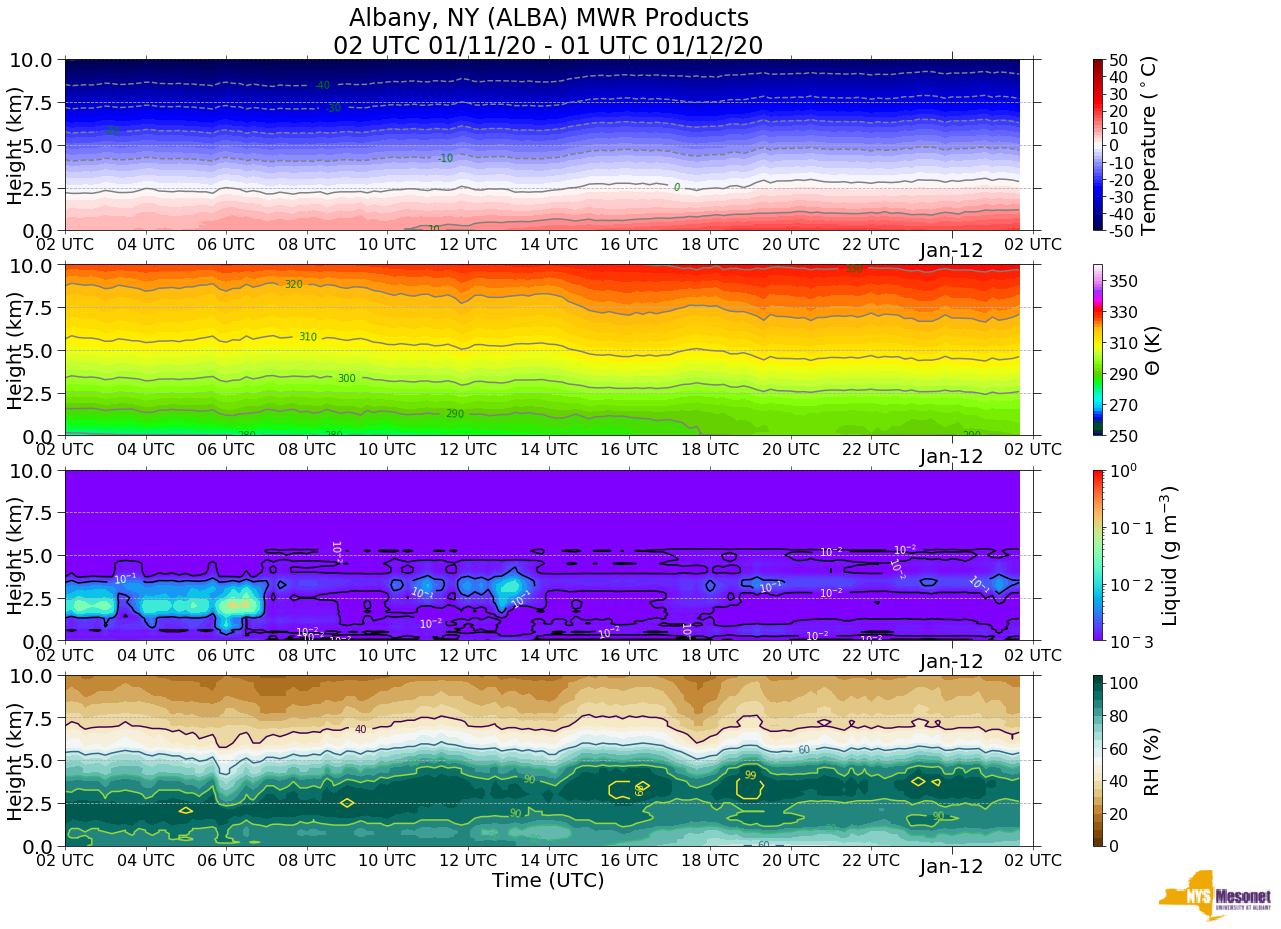

plotted MWR for ALBA


In [33]:
plot_mwr(mwr_4plot_df,station, station_name, logo_path, curr_dt)

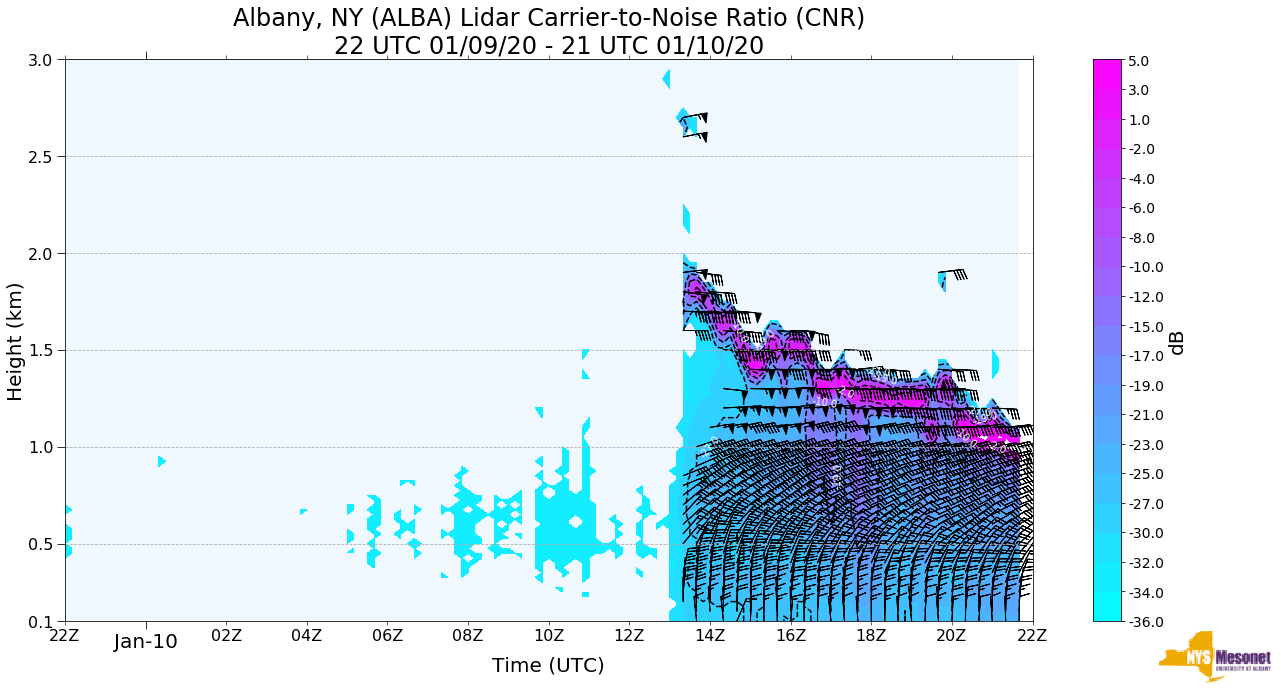

plotted cnr Lidar for ALBA


In [52]:
lidar_field_plotting(station, station_name, lidar_df, 'cnr', logo_path, curr_dt)

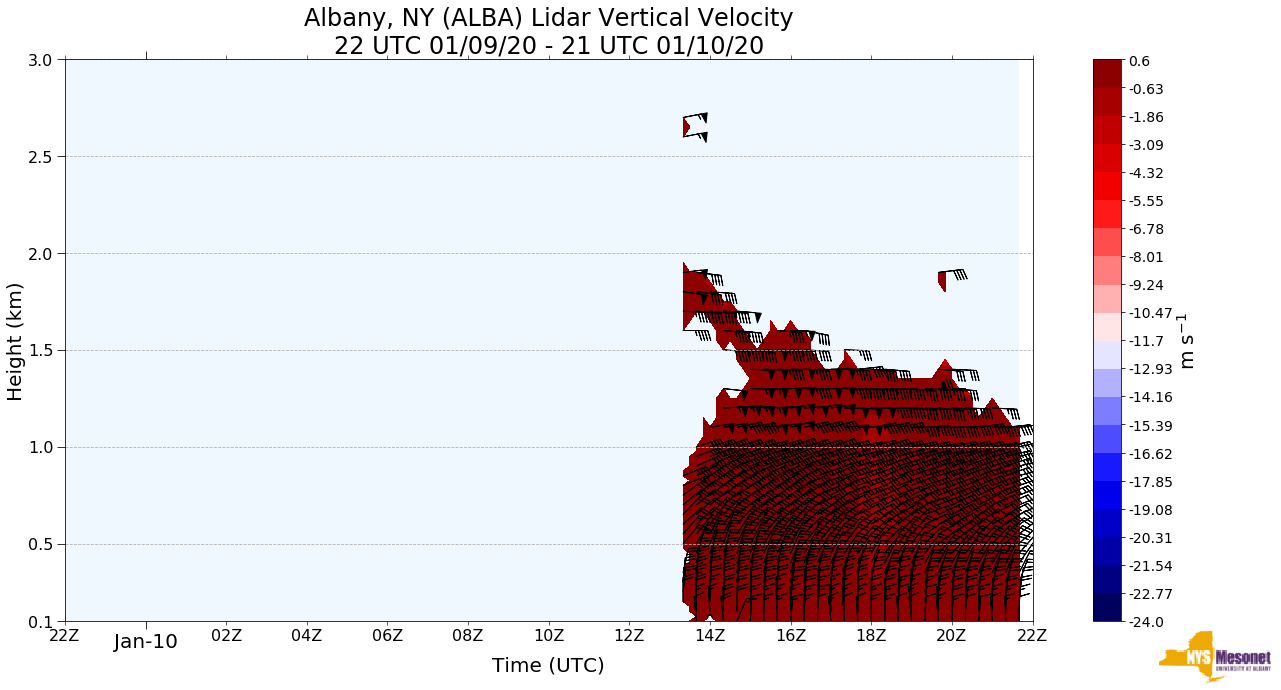

plotted w Lidar for ALBA


In [53]:
lidar_field_plotting(station, station_name, lidar_df, 'w', logo_path, curr_dt)

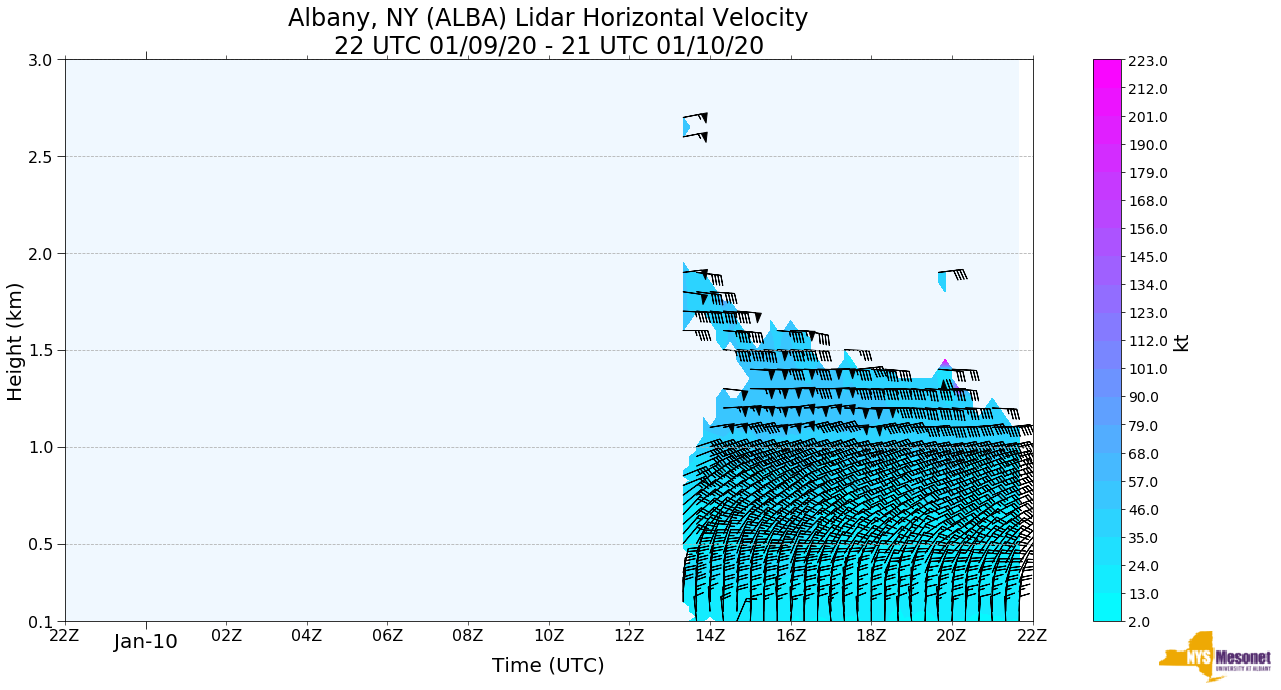

plotted velocity Lidar for ALBA


In [54]:
lidar_field_plotting(station, station_name, lidar_df, 'velocity', logo_path, curr_dt)

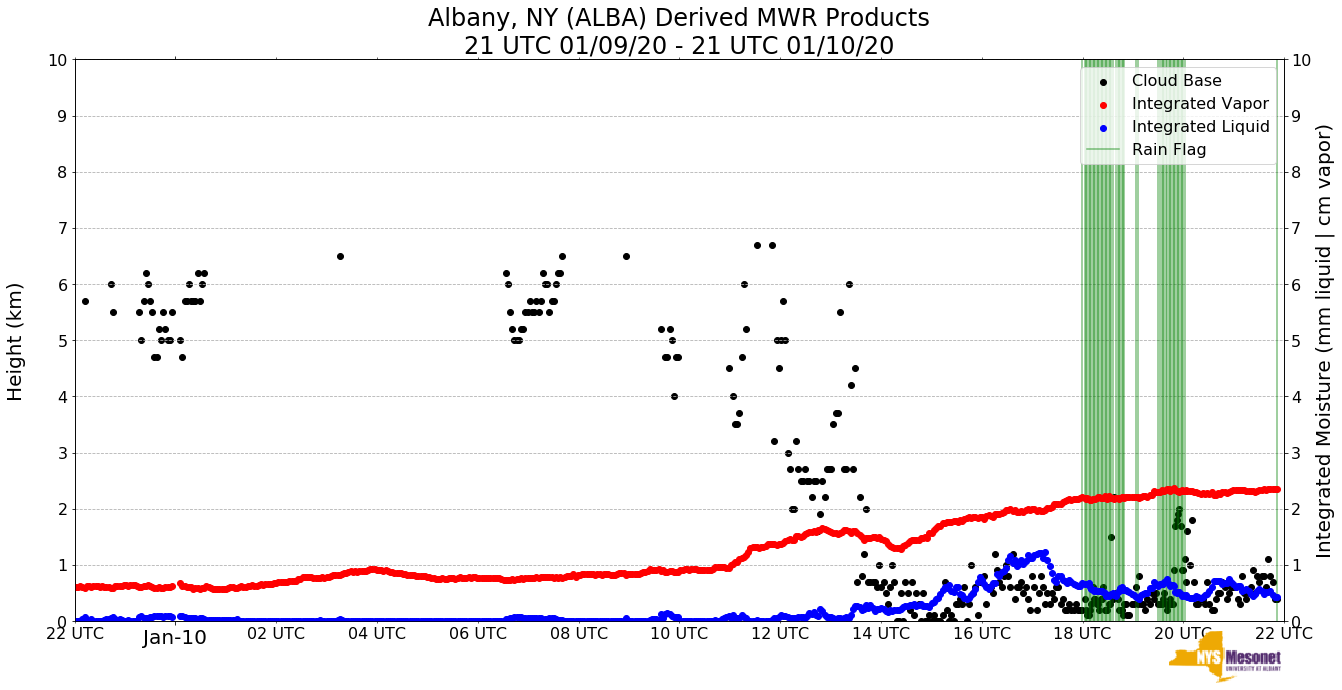

plotted cloud/liquid profile for ALBA


In [71]:
plot_cloud_liquid(mwr_precip_df, station, station_name, logo_path, curr_dt)